## Using scMKL with single-cell mRNA and ATAC Data Simultaneously
Here we will run scMKL on a subset of the MCF-7 data (1,000 cells x 36,601 genes for RNA and 1,000 cells x 206,167 regions for ATAC) using Hallmark groupings.

### Importing Modules
Data is read-in and saved using numpy and pickle modules.

In [1]:
# Packages needed to import data
import numpy as np
import pickle
import sys
from scipy.sparse import load_npz

# This sys command allows us to import the scMKL_src_anndata module from any directory. 
# '..' can be replaced by any path to the repository directory
sys.path.insert(0, '..')
import src.scMKL_src_anndata as src

# Modules for viewing results
import pandas as pd
from plotnine import *

### Reading in Data
There are 4 required pieces of data (per modality) required for scMKL
- The data matrix itself with cells as rows and features as columns.
    - Can be either a Numpy Array or Scipy Sparse array (scipy.sparse.csc_array is the recommended format).  
- The sample labels in a Numpy Array.  To perform group lasso, these labels must be binary and should be the same for each modality.
- Feature names in a Numpy Array. These are the names of the features corresponding with the data matrix
- A dictionary with grouping data.  The keys are the names of the groups, and the values are the corresponding features.
    - Example: {Group1: [feature1, feature2, feature3], Group2: [feature4, feature5, feature6], ...}
    - GSEApy can also be used to access many other gene sets
        - See `getting_RNA_groupings.ipynb` and `getting_RNA_groupings.ipynb` for more information on pulling gene/peak sets

In [2]:
# Reading in RNA data
RNA_group_dict = np.load('./data/RNA_hallmark_groupings.pkl', allow_pickle = True)
RNA_X = load_npz('./data/MCF7_RNA_X.npz')
RNA_feature_names = np.load('./data/MCF7_RNA_feature_names.npy', allow_pickle = True)

# Reading in ATAC data
ATAC_group_dict = np.load('./data/MCF7_ATAC_hallmark_groupings.pkl', allow_pickle = True)
ATAC_X = load_npz('./data/MCF7_ATAC_X.npz')
ATAC_feature_names = np.load('./data/MCF7_ATAC_feature_names.npy', allow_pickle = True)

# Reading in cell labels
cell_labels = np.load('./data/MCF7_cell_labels.npy', allow_pickle = True)

# This value for D, the number of fourier features in Z, was found to be optimal in previous literature. Generally increasing D increases accuracy, but runs slower.
D = int(np.sqrt(len(cell_labels)) * np.log(np.log(len(cell_labels))))

### Creating an AnnData Object
scMKL takes advantage of AnnData's flexible structure to create a straight-forward approach to running scMKL.
`src.Create_Adata` requires: 
- `X` : A data matrix of cells by features can be a numpy array, scipy sparse array or pandas dataframe (sparse array recommended for large datasets)
- `feature_names` : A numpy array of feature names corresponding with the features in `X`
- `cell_labels` : A numpy array of cell phenotypes corresponding with the cells in X (must be binary)
- `group_dict` : Dictionary containing feature grouping information
    - Example: `{geneset: np.array(gene_1, gene_2, ..., gene_n)}`
- `data_type` : `'counts'` or `'binary'`.  Determines what preprocessing is applied to the data
    - Log transforms and standard scales counts data
    - TFIDF filters binary data
- `train_test_split` : Either numpy array of precalculated train/test split for the cells or `None`
    - If `None`, the train test split will be calculated with balanced classes
- `D` : Number of Random Fourier Features used to calculate Z. Should be a positive integer
    - Higher values of D will increase classification accuracy at the cost of computation time
- `filter_features` : Bool whether to filter the features from the dataset
    - Will remove features from X, feature_names not in group_dict and remove features from groupings not in feature_names
- `random_state` : Integer random_state used to set the seed for reproducibilty

In [3]:
# Creating RNA adata
RNA_adata = src.Create_Adata(X = RNA_X, feature_names = RNA_feature_names, cell_labels = cell_labels, group_dict = RNA_group_dict,
                         data_type = 'counts', D = D, filter_features = True, random_state = 100)

# Creating ATAC adata
ATAC_adata = src.Create_Adata(X = ATAC_X, feature_names = ATAC_feature_names, cell_labels = cell_labels, group_dict = ATAC_group_dict,
                         data_type = 'binary', D = D, filter_features = True, random_state = 100)

### Estimating Kernel Widths
`sigma` refers to kernel widths of approximate kernels and should be estimated when running scMKL with `src.Estimate_Sigma()` with parameters:
- `adata` : Adata obj as created by `Create_Adata`
- `n_features` : Number of random features to include when estimating sigma
    - Will be scaled for the whole pathway set according to a heuristic (for scalability)

Returns adata object with sigma array in `adata.uns['sigma']`

In [4]:
# Estamating sigma for RNA
RNA_adata = src.Estimate_Sigma(RNA_adata, n_features = 200)

# Estimating sigma for ATAC
ATAC_adata = src.Estimate_Sigma(ATAC_adata, n_features = 200)

### Calculating Z
The Z matrices are a dimensional reduction of the original single-cell matrix grouped by group_dict groupings and separated by train/test split.

Here we calculate Z using the `Calculate_Z` function with:
- `adata` : Adata obj as created by `Create_Adata` with `'sigma'` key in `adata.uns`
    - Sigma can be calculated with `Estimate_Sigma` or a heuristic but must be positive
- `n_features` : Number of random features to use when calculating Z (used for scalability)

Returns Z matrices for training and testing in adata object with `adata.uns['Z_train']` and `adata.uns['Z_test']`

In [5]:
# Creating Z matrix for RNA
RNA_adata = src.Calculate_Z(RNA_adata, n_features = 5000)

# Creating Z matrix for ATAC
ATAC_adata = src.Calculate_Z(ATAC_adata, n_features = 5000)

## Combining Modalities into a Single Object
`Combine_Modalities` allows us to put our modalitt specific AnnData objects into one object using:
- `Assay_#_name` : Name of assay to be added to group_names as a string if overlap
- `Assay_#_adata` : Anndata object containing Z matrices and annotations
- `combination`: How to combine the matrices, either sum or concatenate
Returns a single AnnData object with both modalities

In [6]:
# Combining adatas
combined_adata = src.Combine_Modalities(Assay_1_name = 'RNA', Assay_2_name = 'ATAC',
                       Assay_1_adata = RNA_adata, Assay_2_adata = ATAC_adata,
                       combination = 'concatenate')

### Optimizing Sparsity
Sparsity (lambda) or alpha here, is the regularization coefficient that controls the pentalty to run with the model.

This will ultimately decide how many groups will be used in the final model.

We can calculate the best performing sparsity  argument from the training data using cross-validation with `Multimodal_Optimize_Alpha`, which requires:
- `adataX` : Anndata objects with Z_train and Z_test calculated (uses unimodal AnnData objects for cross validation)
- `group_size` : Argument describing how the features are grouped
    - From Celer documentation:
        - "groupsint | list of ints | list of lists of ints
            - Partition of features used in the penalty on w
                - If an int is passed, groups are contiguous blocks of features, of size groups
                - If a list of ints is passed, groups are assumed to be contiguous, group number g being of size groups[g]
                - If a list of lists of ints is passed, groups[g] contains the feature indices of the group number g"
        - If 1, model will behave identically to Lasso Regression
- `tifidf_list` : a boolean mask where `tfidf_list[0]` and `tfidf_list[1]` are respective to `adata1` and `adata2`
    - If `True` for one or both of the elements, tfidf normalization will be applied to the respective adata during cross validation
- `starting_alpha` : The alpha value to start the search at
- `alpha_array` : Numpy array of all alpha values to be tested
- `k` : number of folds to perform cross validation over

Returns a single sparsity value as the optimal sparsity aregument for training the model

**NOTE: This step take a while to run and may want to be skipped if running the model with multiple sparsity areguments.**

In [9]:
# Setting a list of alpha values to train the model with
alpha_list = np.round(np.linspace(2.2,0.05,10), 2)

# Calculating the best performing alpha from cross validation on training data
alpha_star = src.Multimodal_Optimize_Alpha(adata1 = RNA_adata, adata2 = ATAC_adata, group_size = 2 * D, tfidf_list = [False, False], alpha_array = alpha_list, k = 4)

Fold 1:
 Memory Usage: [0.0, 0.0] GB
Estimating Sigma
Calculating Z
Fold 2:
 Memory Usage: [0.0, 0.0] GB
Estimating Sigma
Calculating Z
Fold 3:
 Memory Usage: [0.0, 0.0] GB
Estimating Sigma
Calculating Z
Fold 4:
 Memory Usage: [0.0, 0.0] GB
Estimating Sigma
Calculating Z


### Training and Evalutating Model
Here we will train and evaluate 10 models, each with a different `alpha`.

`alpha` (or lambda) is a regularization coefficient that deterimines how many groupings will be used to classify the test cells in the final model. Here, we will evalutate the model using a range of alphas (`alpha_list`) to get a range of selected groups.

In [10]:
# Creating variables to capture model performance and results
metric_dict = {}
selected_pathways = {}
group_norms = {}
group_names = list(combined_adata.uns['group_dict'].keys())
predicted = {}
auroc_array = np.zeros(alpha_list.shape)

# Iterating through alpha list, training/testing models, and capturing results
for i, alpha in enumerate(alpha_list):
    
    print(f'  Evaluating model. Alpha: {alpha}', flush = True)

    combined_adata = src.Train_Model(combined_adata, group_size= 2*D, alpha = alpha)
    predicted[alpha], metric_dict[alpha] = src.Predict(combined_adata, metrics = ['AUROC','F1-Score', 'Accuracy', 'Precision', 'Recall'])
    selected_pathways[alpha] = src.Find_Selected_Pathways(combined_adata)
    group_norms[alpha] = [np.linalg.norm(combined_adata.uns['model'].coef_[i * 2 * D: (i + 1) * 2 * D - 1]) for i in np.arange(len(group_names))]

results = {'Metrics' : metric_dict,
           'Selected_pathways' : selected_pathways,
           'Norms' : group_norms,
           'Predictions' : predicted,
           'Group_names' : group_names}

  Evaluating model. Alpha: 2.2
  Evaluating model. Alpha: 1.96
  Evaluating model. Alpha: 1.72
  Evaluating model. Alpha: 1.48
  Evaluating model. Alpha: 1.24
  Evaluating model. Alpha: 1.01
  Evaluating model. Alpha: 0.77
  Evaluating model. Alpha: 0.53
  Evaluating model. Alpha: 0.29
  Evaluating model. Alpha: 0.05


### Model Performance and Top Groups per Alpha

   Alpha   AUROC  Number of Selected Groups  \
0   2.20  0.8670                          3   
1   1.96  0.9120                          4   
2   1.72  0.9352                          5   
3   1.48  0.9519                          6   
4   1.24  0.9674                          9   
5   1.01  0.9788                          9   
6   0.77  0.9838                         10   
7   0.53  0.9877                         16   
8   0.29  0.9903                         33   
9   0.05  0.9903                         64   

                              Top Group  
0           RNA-HALLMARK_G2M_CHECKPOINT  
1  RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY  
2  RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY  
3  RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY  
4  RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY  
5  RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY  
6  RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY  
7  RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY  
8  RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY  
9           RNA-HALLMARK_UV_RESPONSE_DN  


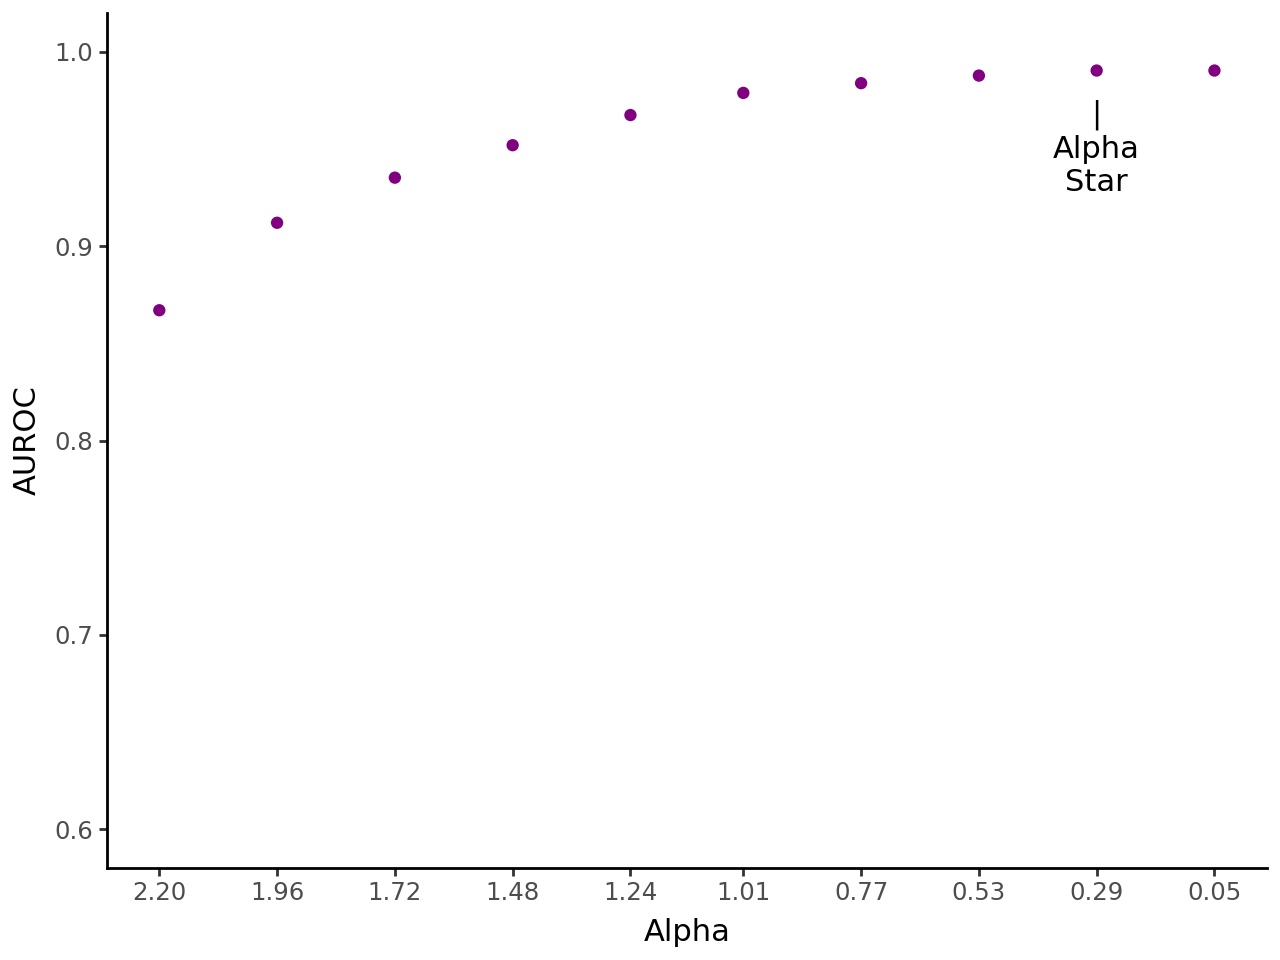

In [11]:
summary = {'Alpha' : [],
           'AUROC' : [],
           'Number of Selected Groups' : [],
           'Top Group' : []}

# Creating summary DataFrame for each model
for alpha in alpha_list:
    summary['Alpha'].append(alpha)
    summary['AUROC'].append(results['Metrics'][alpha]['AUROC'])
    summary['Number of Selected Groups'].append(len(results['Selected_pathways'][alpha]))
    summary['Top Group'].append(*np.array(results['Group_names'])[np.where(results['Norms'][alpha] == max(results['Norms'][alpha]))])
summary = pd.DataFrame(summary)
alpha_star_auroc = float(summary[summary['Alpha'] == alpha_star]['AUROC'])

print(summary)

# Plotting AUROC from each alpha run
(ggplot(summary, aes(x = 'Alpha', y = 'AUROC')) 
 + geom_point(fill = 'purple', color = 'purple') 
 + theme_classic() 
 + ylim(0.6, 1)
 + scale_x_reverse(breaks = alpha_list)
 + annotate('text', x = alpha_star, y = alpha_star_auroc - 0.04, label='|\nAlpha\nStar')
 ).show()